In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from skimage.io import imread
from skimage import img_as_ubyte

# Data loading

In [39]:
dataset = pd.read_csv('Z1-picture_cropping.csv', index_col=0, dtype={'foldername':'object'})
dataset.head()

,breed,file,xmin,ymin,xmax,ymax,foldername,filename,dog_number,prepfilename,xdelta,ydelta
n02085620_10074,Chihuahua,n02085620_10074,25.0,10.0,276.0,498.0,02085620,n02085620_10074,1,n02085620_10074-Chihuahua_cr1,251.0,488.0
n02085620_10131,Chihuahua,n02085620_10131,49.0,9.0,393.0,493.0,02085620,n02085620_10131,1,n02085620_10131-Chihuahua_cr1,344.0,484.0
n02085620_10621,Chihuahua,n02085620_10621,142.0,43.0,335.0,250.0,02085620,n02085620_10621,1,n02085620_10621-Chihuahua_cr1,193.0,207.0
n02085620_1073,Chihuahua,n02085620_1073,0.0,27.0,312.0,498.0,02085620,n02085620_1073,1,n02085620_1073-Chihuahua_cr1,312.0,471.0
n02085620_10976,Chihuahua,n02085620_10976,90.0,104.0,242.0,452.0,02085620,n02085620_10976,1,n02085620_10976-Chihuahua_cr1,152.0,348.0


In [41]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(dataset['breed'])
#print(le.classes_)
dataset['breed_code'] = le.transform(dataset['breed'])
dataset.head()

,breed,file,xmin,ymin,xmax,ymax,foldername,filename,dog_number,prepfilename,xdelta,ydelta,breed_code
n02085620_10074,Chihuahua,n02085620_10074,25.0,10.0,276.0,498.0,02085620,n02085620_10074,1,n02085620_10074-Chihuahua_cr1,251.0,488.0,17
n02085620_10131,Chihuahua,n02085620_10131,49.0,9.0,393.0,493.0,02085620,n02085620_10131,1,n02085620_10131-Chihuahua_cr1,344.0,484.0,17
n02085620_10621,Chihuahua,n02085620_10621,142.0,43.0,335.0,250.0,02085620,n02085620_10621,1,n02085620_10621-Chihuahua_cr1,193.0,207.0,17
n02085620_1073,Chihuahua,n02085620_1073,0.0,27.0,312.0,498.0,02085620,n02085620_1073,1,n02085620_1073-Chihuahua_cr1,312.0,471.0,17
n02085620_10976,Chihuahua,n02085620_10976,90.0,104.0,242.0,452.0,02085620,n02085620_10976,1,n02085620_10976-Chihuahua_cr1,152.0,348.0,17


In [42]:
#dataset downsizing
dataset = dataset[dataset['breed_code'] <=20]
dataset.shape

(3629, 13)

# OpenCV features

In [43]:
import cv2

## Swift

(array([[ 65.,   9.,  52., ...,   0.,   0.,   1.],
       [  8.,   2.,   1., ...,  23.,  13.,   1.],
       [ 92.,  23.,   0., ...,  20.,  13.,  11.],
       ...,
       [  0.,   0.,   0., ...,  10.,  32.,  20.],
       [119.,   7.,   1., ...,   0.,   0.,   0.],
       [137.,  33.,   3., ...,   0.,   0.,   0.]], dtype=float32), array([[[162,  62,  60],
        [152,  52,  50],
        [146,  43,  44],
        ...,
        [226, 158, 137],
        [215, 144, 124],
        [207, 132, 113]],

       [[163,  65,  64],
        [151,  51,  51],
        [143,  40,  43],
        ...,
        [234, 166, 143],
        [224, 153, 131],
        [215, 143, 121]],

       [[173,  74,  77],
        [159,  58,  62],
        [149,  46,  50],
        ...,
        [220, 153, 126],
        [214, 144, 118],
        [207, 135, 110]],

       ...,

       [[115, 109,  51],
        [101,  95,  35],
        [ 91,  87,  26],
        ...,
        [142, 167, 109],
        [123, 143,  80],
        [108, 123,  56]]

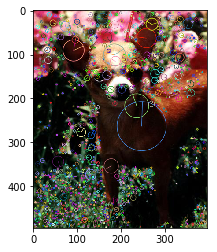

In [44]:
def sift_features(picture):
    imcv = img_as_ubyte(picture)
    imcv_gr = cv2.cvtColor(imcv, cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    
    imcv_kp, imcv_desc = sift.detectAndCompute(imcv_gr, None)
    
    #plt.imshow(cv2.drawKeypoints(imcv, imcv_kp, imcv,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
    
    return imcv_desc, cv2.drawKeypoints(imcv, imcv_kp, imcv,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

picture = imread('../Images/n02085620-Chihuahua/n02085620_10131.jpg')
print(sift_features(picture))
plt.imshow(picture)

## Dominant color

In [45]:
def color_domincance(picture, n_cluster=20):
    #Converts to openCV
    imcv = img_as_ubyte(picture)
        
    #Flatten all the pixels
    Z = imcv.reshape((-1,3))

    # convert to np.float32
    Z = np.float32(Z)

    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = n_cluster
    ret, label, color_dominance = cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    return color_dominance

picture = imread('../Images/n02085620-Chihuahua/n02085620_10131.jpg')
color_domincance(picture)

array([[177.50914  ,  70.84581  ,  55.230648 ],
       [106.92459  , 133.77016  ,  99.46756  ],
       [119.29099  ,  96.78363  ,  65.19651  ],
       [199.74805  , 124.64813  ,  89.33971  ],
       [213.74004  ,  75.71417  , 111.616234 ],
       [ 74.08745  ,  20.798048 ,  13.02246  ],
       [144.16626  , 130.15932  ,  92.68206  ],
       [ 79.94241  , 109.940544 ,  78.17195  ],
       [ 55.70974  ,  87.57425  ,  59.98867  ],
       [248.20087  , 200.4527   , 190.6657   ],
       [  8.961449 ,   6.4185147,   3.579963 ],
       [ 76.77774  ,  90.12923  ,  51.038563 ],
       [ 93.68758  ,  54.46293  ,  39.09379  ],
       [221.12703  , 182.6861   , 142.1556   ],
       [ 42.24255  ,  62.9507   ,  36.330482 ],
       [167.37805  , 165.75403  , 123.53595  ],
       [237.73581  , 137.73813  , 159.6821   ],
       [135.17686  ,  37.93419  ,  25.553143 ],
       [252.05492  , 238.93626  , 232.80339  ],
       [ 30.17646  ,  29.220394 ,  16.117699 ]], dtype=float32)

# Picture loading and treatment

In [46]:
from skimage.restoration import estimate_sigma, denoise_nl_means
from skimage.filters import gaussian
from skimage import exposure
from skimage.util import crop
from PIL import Image

def pictureloader(picture, save_file=True):
    
    xmax = int(picture.xmax)
    ymax = int(picture.ymax)
    xmin = int(picture.xmin)
    ymin = int(picture.ymin)
    foldername = picture.foldername
    breed = picture.breed
    filename = picture.filename
    prepfilename = picture.prepfilename
    breed_code = picture.breed_code
        
    #Image opening
    img = imread('../Images/n{}-{}/{}.jpg'.format(foldername, breed, filename))
            
    #Image cropping
    area = (xmin, ymin, xmax, ymax)
    img = Image.fromarray(img).crop(area)
    img=np.array(img)
            
    #Image equalization
    img = exposure.equalize_hist(img)
            
    #Gaussian blur fliter
    img = gaussian(img, sigma=1, multichannel=True)
    
    
    #Non linear mean
    patch_kw = dict(patch_size=5,      # 5x5 patches
                        patch_distance=6,  # 13x13 search area
                        multichannel=True)
    #sigma_est = np.mean(estimate_sigma(img, multichannel=True, average_sigmas=False))
    #img = denoise_nl_means(img, h=10*sigma_est, fast_mode=True, **patch_kw)

    descriptors, pic = sift_features(img)
    colors = color_domincance(img)
    
    #plt.imshow(pic)
    #plt.show()
    
    if save_file:
        cv2.imwrite('../pics/{}.jpg'.format(prepfilename),pic)

    
    return descriptors, colors, breed_code

descriptors, colors , breed_code = pictureloader(dataset.iloc[1])

/Users/cricket/anaconda3/lib/python3.6/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "
/Users/cricket/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


# Dataset creation

In [47]:
keypoints = []
colors = []
y = []

for _, picture in dataset.iterrows():
    descriptors, colorsdom, breed = pictureloader(picture, save_file=False)
    keypoints.append(descriptors)
    colors.append(colorsdom)
    y.append(breed)

X = np.array([keypoints, colors])
y = np.array(y)

/Users/cricket/anaconda3/lib/python3.6/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "
/Users/cricket/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [48]:
d = {'kp':keypoints, 'colors':colors, 'breed':y}
df = pd.DataFrame(data=d)
df['colors'] = df['colors'].apply(np.array)
df['kp'] = df['kp'].apply(np.array)

# Dataset saving

In [49]:
np.savez('Z2 - bowsift', X=X, y=y)

# Dataset loading

In [50]:
saved = np.load('Z2 - bowsift.npz')
saved.files

['X', 'y']

# Data separation

In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[['kp', 'colors']], df['breed'], test_size=0.33, random_state=0, stratify=df['breed'])


In [52]:
X_train['kp'].tolist()

[array([[  0.,   0.,   0., ...,  39.,  27.,  18.],
        [114.,  21.,   2., ...,   0.,   0.,   3.],
        [  0.,   0.,   1., ...,  56.,  24.,   0.],
        ...,
        [  0.,   0.,   0., ...,  16.,  50.,  27.],
        [  3.,   4.,   8., ...,   0.,   0.,   0.],
        [ 33.,  62.,  96., ...,   0.,   0.,   0.]], dtype=float32),
 array([[ 51.,   5.,   0., ...,   0.,   0.,  10.],
        [ 24.,   8.,   0., ...,   0.,   0.,   2.],
        [ 19.,  31.,   3., ...,   0.,   0.,   1.],
        ...,
        [ 10.,   6.,  13., ...,   0.,   0.,   3.],
        [  4., 139.,  35., ...,   0.,   0.,   2.],
        [  1.,   6.,   6., ...,   0.,   1.,   4.]], dtype=float32),
 array([[ 23.,   1.,   0., ...,   0.,   0.,   0.],
        [ 57.,   0.,   0., ..., 127.,  49.,   6.],
        [  2.,  78., 149., ...,   0.,   0.,   0.],
        ...,
        [  1.,   1.,   2., ...,   1.,   1.,  16.],
        [  2.,   2.,   2., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,  16.,  27.,  39.]], dtype=fl

# Blocs creation

In [53]:
from sklearn.base import BaseEstimator, TransformerMixin

## Standardisation

In [54]:
from sklearn.preprocessing import StandardScaler

class Standselector(BaseEstimator, TransformerMixin):
    
    def __init__(self, column):
        self.scaler = StandardScaler()
        self.column = column
    
    def fit(self, X, y=None):
        Xasm = np.concatenate(X[self.column].tolist())
        self.scaler.fit(Xasm)
        return self
        
    
    def transform(self, X, y=None):
        toreturn = []
        for color in X[self.column]:
            toreturn.append(self.scaler.transform(color))
        return toreturn

colorstand = Standselector('kp')
colorstand.fit(X_train)
color_std = colorstand.transform(X_train)
#color_std

## Kmeans

In [55]:
A = np.random.randint(5, size=(10,3))
idx = np.random.randint(A.shape[0], size=3)
A[idx,:]

array([[0, 1, 1],
       [2, 2, 3],
       [2, 0, 3]])

In [56]:
A.shape[0]


10

In [97]:
from sklearn.cluster import KMeans

class KmeansPlus(BaseEstimator, TransformerMixin):
    
    def __init__(self, **kwargs):
        self.params = {'n_clusters':50, 'verbose':0, 'random_state':0, 'max_iter': 300, **kwargs}
        self.kmeans = KMeans(**self.params)
    
    def fit(self, X, y=None):
        Xasm = np.concatenate(X)
        
        idx = np.random.randint(Xasm.shape[0], size=10000)
        Xsample = Xasm[idx,:]
        
        self.kmeans.fit(Xsample)
        return self
        
    
    def transform(self, X, y=None):
        toreturn = []
        for color in X:
            color = self.kmeans.predict(color)
            toappend = ' '.join(['c{}'.format(x) for x in color])
            toreturn.append(toappend)
        return toreturn
    
#    def get_params(self, deep=True):
#        return self.params
#    
#    def set_params(self, **params):
#        self.params = {**self.params, **params}
#        self.kmeans.set_params(**params)
#        return self

colorkmeans = KmeansPlus()
colorkmeans.fit(color_std)
bagofcolors = colorkmeans.transform(color_std)
bagofcolors

['c4 c49 c25 c22 c47 c13 c0 c28 c47 c3 c9 c13 c0 c23 c28 c0 c13 c31 c16 c47 c39 c32 c2 c43 c11 c3 c12 c2 c36 c19 c48 c10 c21 c0 c8 c31 c3 c1 c1 c21 c14 c8 c10 c30 c2 c32 c18 c5 c23 c27 c8 c45 c10 c9 c2 c42 c2 c3 c26 c42 c18 c43 c46 c3 c11 c46 c40 c25 c14 c14 c18 c37 c48 c48 c37 c16 c28 c38 c0 c20 c28 c0 c48 c38 c41 c7 c37 c49 c13 c16 c10 c31 c21 c31 c37 c0 c12 c17 c17 c1 c37 c28 c22 c27 c21 c6 c49 c44 c23 c8 c21 c21 c33 c32 c41 c8 c41 c22 c19 c16 c22 c11 c25 c43 c4 c45 c9 c47 c10 c23 c42 c26 c1 c34 c12 c48 c17 c1 c47 c34 c14 c40 c20 c2 c11 c20 c46 c36 c11 c29 c29 c24 c14 c49 c40 c40 c49 c33 c18 c26 c43 c25 c6 c28 c36 c40 c20 c18 c39 c20 c18 c8 c33 c37 c41 c21 c20 c2 c6 c18 c16 c31 c11 c41 c33 c31 c8 c39 c26 c11 c18 c25 c20 c49 c44 c43 c15 c16 c11 c16 c34 c21 c0 c14 c22 c36 c6',
 'c21 c21 c21 c21 c21 c21 c2 c21 c21 c21 c2 c21 c18 c21 c2 c43 c42 c21 c21 c18 c28 c47 c29 c49 c24 c21 c13 c33 c34 c41 c2 c33 c39 c24 c21 c18 c32 c24 c49 c9 c10 c9 c24 c37 c12 c3 c21 c10 c37 c47 c10 c3 c41 c31 c

In [98]:
colorkmeans.get_params()

{}

In [96]:
colorkmeans.get_params()

{'max_iter': 300, 'n_clusters': 50, 'random_state': 0, 'verbose': 0}

## Counvectorizer

In [58]:
from sklearn.feature_extraction.text import CountVectorizer

class CvectPlus(BaseEstimator, TransformerMixin):
    
    def __init__(self, **kwargs):
        self.params = {'max_df':1.0, 'min_df':1, 'max_features':None, 'analyzer':'word', **kwargs}
        self.cvect = CountVectorizer(**self.params)
    
    def fit(self, X, y=None):
        self.cvect.fit(X)
        return self
        
    
    def transform(self, X, y=None):
        return self.cvect.transform(X)
    
    def get_params(self, deep=True):
        return self.params
    
    def set_params(self, **params):
        self.params = {**self.params, **params}
        self.kmeans.set_params(**params)
        return self

colorcvect = CvectPlus()
colorcvect.fit(bagofcolors)
colorcvect.transform(bagofcolors)

<2431x50 sparse matrix of type '<class 'numpy.int64'>'
	with 117827 stored elements in Compressed Sparse Row format>

# Pipelines creation

In [59]:
from sklearn.pipeline import Pipeline

In [60]:
#Color pipe
pipecol = [('stdcol', Standselector('colors')), ('kmcol',KmeansPlus()), ('cvectcol', CvectPlus())]
colorpipe = Pipeline(pipecol)

In [83]:
#descriptors pipe
pipekp = [('stdkp', Standselector('kp')), ('kmkp',KmeansPlus()), ('cvectkp', CvectPlus())]
kppipe = Pipeline(pipekp)

# Feature union

In [62]:
from sklearn.pipeline import FeatureUnion
features = [('kp', kppipe), ('color', colorpipe)]
featureasm = FeatureUnion(features)

# Scoring method

In [80]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

scorer = make_scorer(accuracy_score)

# Cross Validation

In [84]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=3)


## Only KP

## Classifier creation

In [63]:
from sklearn.ensemble import RandomForestClassifier

In [79]:
pipekponly = [('stdkp', Standselector('kp')), ('kmkp',KmeansPlus()), ('cvectkp', CvectPlus()), ('rfc',RandomForestClassifier(n_estimators=1000, max_depth=100))]
clfkponly = Pipeline(pipekponly)
clfkponly.fit(X_train, y_train)

clfkponly.score(X_test, y_test)

0.17779632721202004

In [81]:
accuracy_score(y_test, clfkponly.predict(X_test))

0.17779632721202004

## Gridsearch

In [88]:
from sklearn.model_selection import GridSearchCV

parameters = {'kmkp__n_clusters':[30,90]}

clfkponlygs = GridSearchCV(clfkponly, param_grid=parameters, scoring=scorer, n_jobs=-2, cv=skf, verbose=5)

clfkponlygs.fit(X_train, y_train)


Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] kmkp__n_clusters=30 .............................................
[CV] kmkp__n_clusters=30 .............................................
[CV] kmkp__n_clusters=30 .............................................
[CV] .... kmkp__n_clusters=30, score=0.1356968215158924, total= 2.1min
[CV] kmkp__n_clusters=90 .............................................
[CV] ... kmkp__n_clusters=30, score=0.17206982543640897, total= 6.3min
[CV] kmkp__n_clusters=90 .............................................
[CV] .... kmkp__n_clusters=30, score=0.1504315659679408, total= 7.9min


[Parallel(n_jobs=-2)]: Done   3 out of   6 | elapsed: 14.5min remaining: 14.5min


[CV] ... kmkp__n_clusters=90, score=0.16276202219482122, total=  48.5s
[CV] ... kmkp__n_clusters=90, score=0.17603911980440098, total= 6.2min
[CV] kmkp__n_clusters=90 .............................................
[CV] ... kmkp__n_clusters=90, score=0.17955112219451372, total=  49.6s


[Parallel(n_jobs=-2)]: Done   6 out of   6 | elapsed: 15.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('stdkp', Standselector(column='kp')), ('kmkp', KmeansPlus(max_iter=300, n_clusters=50, random_state=0, verbose=0)), ('cvectkp', CvectPlus(analyzer='word', max_df=1.0, max_features=None, min_df=1)), ('rfc', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
          ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'kmkp__n_clusters': [30, 90]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn',
       scoring=make_scorer(accuracy_score), verbose=5)

In [89]:
clfkponlygs.score(X_test, y_test)

0.18030050083472454

In [90]:
clfkponlygs.best_params_

{'kmkp__n_clusters': 90}

# KP and colors

In [76]:
clflist = [('featureasm',featureasm), ('rfc',RandomForestClassifier(n_estimators=1000, max_depth=100))]
clfpipe = Pipeline(clflist)

In [77]:
clfpipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('featureasm', FeatureUnion(n_jobs=1,
       transformer_list=[('kp', Pipeline(memory=None,
     steps=[('stdkp', Standselector(column='kp')), ('kmkp', KmeansPlus(max_iter=300, n_clusters=50, random_state=0, verbose=0)), ('cvectkp', CvectPlus(analyzer='word', max_df=1.0, max_features=None, mi...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [78]:
clfpipe.score(X_test, y_test)

0.24040066777963273

## Key point optimization

In [94]:
parameters = {'featureasm__kmkp__n_clusters':[100, 150, 200], 'featureasm__kmcol__n_clusters':[6,10,15]}

clfkpcolorsgs = GridSearchCV(clfpipe, param_grid=parameters, scoring=scorer, n_jobs=-2, cv=skf, verbose=5)

clfkpcolorsgs.fit(X_train, y_train)
clfkpcolorsgs.best_params_

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] featureasm__kmcol__n_clusters=6, featureasm__kmkp__n_clusters=100 
[CV] featureasm__kmcol__n_clusters=6, featureasm__kmkp__n_clusters=100 
[CV] featureasm__kmcol__n_clusters=6, featureasm__kmkp__n_clusters=100 


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/Users/cricket/anaconda3/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x10bddbe40, file "/Use...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/cricket/anaconda3/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Users/cricket/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/crick.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x10bddbe40, file "/Use...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/cricket/anaconda3/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Users/cricket/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/crick.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    107         except RuntimeError:
    108             old_loop = None
    109         try:
    110             self._setup_logging()
    111             asyncio.set_event_loop(self.asyncio_loop)
--> 112             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Uni...EventLoop running=True closed=False debug=False>>
    113         finally:
    114             asyncio.set_event_loop(old_loop)
    115 
    116     def stop(self):

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/asyncio/base_events.py in run_forever(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
    416             sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    417                                    finalizer=self._asyncgen_finalizer_hook)
    418         try:
    419             events._set_running_loop(self)
    420             while True:
--> 421                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_UnixS...EventLoop running=True closed=False debug=False>>
    422                 if self._stopping:
    423                     break
    424         finally:
    425             self._stopping = False

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/asyncio/base_events.py in _run_once(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
   1426                         logger.warning('Executing %s took %.3f seconds',
   1427                                        _format_handle(handle), dt)
   1428                 finally:
   1429                     self._current_handle = None
   1430             else:
-> 1431                 handle._run()
        handle._run = <bound method Handle._run of <Handle BaseAsyncIOLoop._handle_events(15, 1)>>
   1432         handle = None  # Needed to break cycles when an exception occurs.
   1433 
   1434     def _set_coroutine_wrapper(self, enabled):
   1435         try:

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/asyncio/events.py in _run(self=<Handle BaseAsyncIOLoop._handle_events(15, 1)>)
    140             self._callback = None
    141             self._args = None
    142 
    143     def _run(self):
    144         try:
--> 145             self._callback(*self._args)
        self._callback = <bound method BaseAsyncIOLoop._handle_events of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (15, 1)
    146         except Exception as exc:
    147             cb = _format_callback_source(self._callback, self._args)
    148             msg = 'Exception in callback {}'.format(cb)
    149             context = {

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py in _handle_events(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, fd=15, events=1)
     97             self.writers.remove(fd)
     98         del self.handlers[fd]
     99 
    100     def _handle_events(self, fd, events):
    101         fileobj, handler_func = self.handlers[fd]
--> 102         handler_func(fileobj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fileobj = <zmq.sugar.socket.Socket object>
        events = 1
    103 
    104     def start(self):
    105         try:
    106             old_loop = asyncio.get_event_loop()

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "parameters = {'featureasm__kmkp__n_clusters':[10....fit(X_train, y_train)\nclfkpcolorsgs.best_params_", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 26, 3, 22, 41, 549248, tzinfo=datetime.timezone.utc), 'msg_id': 'f7e62d0d3c0e4964b37c72eb83f570b4', 'msg_type': 'execute_request', 'session': 'f57012694a2f4f9180e1d742e0b6c3b9', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'f7e62d0d3c0e4964b37c72eb83f570b4', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'f57012694a2f4f9180e1d742e0b6c3b9']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "parameters = {'featureasm__kmkp__n_clusters':[10....fit(X_train, y_train)\nclfkpcolorsgs.best_params_", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 26, 3, 22, 41, 549248, tzinfo=datetime.timezone.utc), 'msg_id': 'f7e62d0d3c0e4964b37c72eb83f570b4', 'msg_type': 'execute_request', 'session': 'f57012694a2f4f9180e1d742e0b6c3b9', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'f7e62d0d3c0e4964b37c72eb83f570b4', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'f57012694a2f4f9180e1d742e0b6c3b9'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "parameters = {'featureasm__kmkp__n_clusters':[10....fit(X_train, y_train)\nclfkpcolorsgs.best_params_", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 26, 3, 22, 41, 549248, tzinfo=datetime.timezone.utc), 'msg_id': 'f7e62d0d3c0e4964b37c72eb83f570b4', 'msg_type': 'execute_request', 'session': 'f57012694a2f4f9180e1d742e0b6c3b9', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'f7e62d0d3c0e4964b37c72eb83f570b4', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="parameters = {'featureasm__kmkp__n_clusters':[10....fit(X_train, y_train)\nclfkpcolorsgs.best_params_", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "parameters = {'featureasm__kmkp__n_clusters':[10....fit(X_train, y_train)\nclfkpcolorsgs.best_params_"
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("parameters = {'featureasm__kmkp__n_clusters':[10....fit(X_train, y_train)\nclfkpcolorsgs.best_params_",), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("parameters = {'featureasm__kmkp__n_clusters':[10....fit(X_train, y_train)\nclfkpcolorsgs.best_params_",)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="parameters = {'featureasm__kmkp__n_clusters':[10....fit(X_train, y_train)\nclfkpcolorsgs.best_params_", store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Expr object>], cell_name='<ipython-input-94-717f5a38be5c>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 1e5f1fb550, execution..._before_exec=None error_in_exec=None result=None>)
   2845 
   2846         try:
   2847             for i, node in enumerate(to_run_exec):
   2848                 mod = ast.Module([node])
   2849                 code = compiler(mod, cell_name, "exec")
-> 2850                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x1db71771e0, file "<ipython-input-94-717f5a38be5c>", line 5>
        result = <ExecutionResult object at 1e5f1fb550, execution..._before_exec=None error_in_exec=None result=None>
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x1db71771e0, file "<ipython-input-94-717f5a38be5c>", line 5>, result=<ExecutionResult object at 1e5f1fb550, execution..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x1db71771e0, file "<ipython-input-94-717f5a38be5c>", line 5>
        self.user_global_ns = {'A': array([[3, 4, 2],
       [2, 2, 3],
       [0, 1...  [1, 1, 4],
       [2, 0, 3],
       [3, 4, 0]]), 'BaseEstimator': <class 'sklearn.base.BaseEstimator'>, 'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'CvectPlus': <class '__main__.CvectPlus'>, 'FeatureUnion': <class 'sklearn.pipeline.FeatureUnion'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'Image': <module 'PIL.Image' from '/Users/cricket/anaconda3/lib/python3.6/site-packages/PIL/Image.py'>, 'In': ['', 'import numpy as np\nimport matplotlib.pyplot as p...io import imread\nfrom skimage import img_as_ubyte', "dataset = pd.read_csv('Z1-picture_cropping.csv',...=0, dtype={'foldername':'object'})\ndataset.head()", "from sklearn import preprocessing\n\nle = preproce...] = le.transform(dataset['breed'])\ndataset.head()", "#dataset downsizing\ndataset = dataset[dataset['breed_code'] <=5]\ndataset.shape", 'import cv2', 'def sift_features(picture):\n    imcv = img_as_ub...print(sift_features(picture))\nplt.imshow(picture)', "def color_domincance(picture, n_cluster=20):\n   ...a/n02085620_10131.jpg')\ncolor_domincance(picture)", 'from skimage.restoration import estimate_sigma, ...ors , breed_code = pictureloader(dataset.iloc[1])', 'keypoints = []\ncolors = []\ny = []\n\nfor _, pictur...X = np.array([keypoints, colors])\ny = np.array(y)', "d = {'kp':keypoints, 'colors':colors, 'breed':y}...ply(np.array)\ndf['kp'] = df['kp'].apply(np.array)", "np.savez('Z2 - bowsift', X=X, y=y)", "saved = np.load('Z2 - bowsift.npz')\nsaved.files", "from sklearn.model_selection import train_test_s..._size=0.33, random_state=0, stratify=df['breed'])", "X_train['kp'].tolist()", 'from sklearn.base import BaseEstimator, TransformerMixin', 'from sklearn.preprocessing import StandardScaler...lor_std = colorstand.transform(X_train)\ncolor_std', 'from sklearn.cluster import KMeans\n\nclass Kmeans...rs = colorkmeans.transform(color_std)\nbagofcolors', 'A = np.random.randint(5, size=(10,3))\nidx = np.random.randint(10, size=2)\nA[idx,:]', 'A', ...], 'KMeans': <class 'sklearn.cluster.k_means_.KMeans'>, 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, ...}
        self.user_ns = {'A': array([[3, 4, 2],
       [2, 2, 3],
       [0, 1...  [1, 1, 4],
       [2, 0, 3],
       [3, 4, 0]]), 'BaseEstimator': <class 'sklearn.base.BaseEstimator'>, 'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'CvectPlus': <class '__main__.CvectPlus'>, 'FeatureUnion': <class 'sklearn.pipeline.FeatureUnion'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'Image': <module 'PIL.Image' from '/Users/cricket/anaconda3/lib/python3.6/site-packages/PIL/Image.py'>, 'In': ['', 'import numpy as np\nimport matplotlib.pyplot as p...io import imread\nfrom skimage import img_as_ubyte', "dataset = pd.read_csv('Z1-picture_cropping.csv',...=0, dtype={'foldername':'object'})\ndataset.head()", "from sklearn import preprocessing\n\nle = preproce...] = le.transform(dataset['breed'])\ndataset.head()", "#dataset downsizing\ndataset = dataset[dataset['breed_code'] <=5]\ndataset.shape", 'import cv2', 'def sift_features(picture):\n    imcv = img_as_ub...print(sift_features(picture))\nplt.imshow(picture)', "def color_domincance(picture, n_cluster=20):\n   ...a/n02085620_10131.jpg')\ncolor_domincance(picture)", 'from skimage.restoration import estimate_sigma, ...ors , breed_code = pictureloader(dataset.iloc[1])', 'keypoints = []\ncolors = []\ny = []\n\nfor _, pictur...X = np.array([keypoints, colors])\ny = np.array(y)', "d = {'kp':keypoints, 'colors':colors, 'breed':y}...ply(np.array)\ndf['kp'] = df['kp'].apply(np.array)", "np.savez('Z2 - bowsift', X=X, y=y)", "saved = np.load('Z2 - bowsift.npz')\nsaved.files", "from sklearn.model_selection import train_test_s..._size=0.33, random_state=0, stratify=df['breed'])", "X_train['kp'].tolist()", 'from sklearn.base import BaseEstimator, TransformerMixin', 'from sklearn.preprocessing import StandardScaler...lor_std = colorstand.transform(X_train)\ncolor_std', 'from sklearn.cluster import KMeans\n\nclass Kmeans...rs = colorkmeans.transform(color_std)\nbagofcolors', 'A = np.random.randint(5, size=(10,3))\nidx = np.random.randint(10, size=2)\nA[idx,:]', 'A', ...], 'KMeans': <class 'sklearn.cluster.k_means_.KMeans'>, 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
/Users/cricket/Documents/ONline classes/A7 - Picture analysis/OCR-picture-recognition/Notebooks/<ipython-input-94-717f5a38be5c> in <module>()
      1 parameters = {'featureasm__kmkp__n_clusters':[100, 150, 200], 'featureasm__kmcol__n_clusters':[6,10,15]}
      2 
      3 clfkpcolorsgs = GridSearchCV(clfpipe, param_grid=parameters, scoring=scorer, n_jobs=-2, cv=skf, verbose=5)
      4 
----> 5 clfkpcolorsgs.fit(X_train, y_train)
      6 clfkpcolorsgs.best_params_

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py in fit(self=GridSearchCV(cv=StratifiedKFold(n_splits=3, rand...  scoring=make_scorer(accuracy_score), verbose=5), X=                                                ...364], [131.8124, 14...  

[2431 rows x 2 columns], y=1917    11
1384     2
339      8
1250    10
1842...624     5
Name: breed, Length: 2431, dtype: int64, groups=None, **fit_params={})
    634                                   return_train_score=self.return_train_score,
    635                                   return_n_test_samples=True,
    636                                   return_times=True, return_parameters=False,
    637                                   error_score=self.error_score)
    638           for parameters, (train, test) in product(candidate_params,
--> 639                                                    cv.split(X, y, groups)))
        cv.split = <bound method StratifiedKFold.split of Stratifie...ld(n_splits=3, random_state=None, shuffle=False)>
        X =                                                 ...364], [131.8124, 14...  

[2431 rows x 2 columns]
        y = 1917    11
1384     2
339      8
1250    10
1842...624     5
Name: breed, Length: 2431, dtype: int64
        groups = None
    640 
    641         # if one choose to see train score, "out" will contain train score info
    642         if self.return_train_score:
    643             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-2), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-2)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Sun Mar 25 22:22:50 2018
PID: 2974                 Python 3.6.4: /Users/cricket/anaconda3/bin/python
...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (Pipeline(memory=None,
     steps=[('featureasm',...None, verbose=0,
            warm_start=False))]),                                                 ...364], [131.8124, 14...  

[2431 rows x 2 columns], 1917    11
1384     2
339      8
1250    10
1842...624     5
Name: breed, Length: 2431, dtype: int64, {'score': make_scorer(accuracy_score)}, array([ 694,  697,  707, ..., 2428, 2429, 2430]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ...93, 897, 902, 903, 909, 911, 916, 922, 927, 953]), 5, {'featureasm__kmcol__n_clusters': 6, 'featureasm__kmkp__n_clusters': 100}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (Pipeline(memory=None,
     steps=[('featureasm',...None, verbose=0,
            warm_start=False))]),                                                 ...364], [131.8124, 14...  

[2431 rows x 2 columns], 1917    11
1384     2
339      8
1250    10
1842...624     5
Name: breed, Length: 2431, dtype: int64, {'score': make_scorer(accuracy_score)}, array([ 694,  697,  707, ..., 2428, 2429, 2430]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ...93, 897, 902, 903, 909, 911, 916, 922, 927, 953]), 5, {'featureasm__kmcol__n_clusters': 6, 'featureasm__kmkp__n_clusters': 100})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=Pipeline(memory=None,
     steps=[('featureasm',...None, verbose=0,
            warm_start=False))]), X=                                                ...364], [131.8124, 14...  

[2431 rows x 2 columns], y=1917    11
1384     2
339      8
1250    10
1842...624     5
Name: breed, Length: 2431, dtype: int64, scorer={'score': make_scorer(accuracy_score)}, train=array([ 694,  697,  707, ..., 2428, 2429, 2430]), test=array([  0,   1,   2,   3,   4,   5,   6,   7,  ...93, 897, 902, 903, 909, 911, 916, 922, 927, 953]), verbose=5, parameters={'featureasm__kmcol__n_clusters': 6, 'featureasm__kmkp__n_clusters': 100}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    439                       for k, v in fit_params.items()])
    440 
    441     test_scores = {}
    442     train_scores = {}
    443     if parameters is not None:
--> 444         estimator.set_params(**parameters)
        estimator.set_params = <bound method Pipeline.set_params of Pipeline(me...one, verbose=0,
            warm_start=False))])>
        parameters = {'featureasm__kmcol__n_clusters': 6, 'featureasm__kmkp__n_clusters': 100}
    445 
    446     start_time = time.time()
    447 
    448     X_train, y_train = _safe_split(estimator, X, y, train)

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py in set_params(self=Pipeline(memory=None,
     steps=[('featureasm',...None, verbose=0,
            warm_start=False))]), **kwargs={'featureasm__kmcol__n_clusters': 6, 'featureasm__kmkp__n_clusters': 100})
    137 
    138         Returns
    139         -------
    140         self
    141         """
--> 142         self._set_params('steps', **kwargs)
        self._set_params = <bound method _BaseComposition._set_params of Pi...one, verbose=0,
            warm_start=False))])>
        kwargs = {'featureasm__kmcol__n_clusters': 6, 'featureasm__kmkp__n_clusters': 100}
    143         return self
    144 
    145     def _validate_steps(self):
    146         names, estimators = zip(*self.steps)

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/utils/metaestimators.py in _set_params(self=Pipeline(memory=None,
     steps=[('featureasm',...None, verbose=0,
            warm_start=False))]), attr='steps', **params={'featureasm__kmcol__n_clusters': 6, 'featureasm__kmkp__n_clusters': 100})
     44         names, _ = zip(*getattr(self, attr))
     45         for name in list(six.iterkeys(params)):
     46             if '__' not in name and name in names:
     47                 self._replace_estimator(attr, name, params.pop(name))
     48         # 3. Step parameters and other initilisation arguments
---> 49         super(_BaseComposition, self).set_params(**params)
        self.set_params = <bound method Pipeline.set_params of Pipeline(me...one, verbose=0,
            warm_start=False))])>
        params = {'featureasm__kmcol__n_clusters': 6, 'featureasm__kmkp__n_clusters': 100}
     50         return self
     51 
     52     def _replace_estimator(self, attr, name, new_val):
     53         # assumes `name` is a valid estimator name

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/base.py in set_params(self=Pipeline(memory=None,
     steps=[('featureasm',...None, verbose=0,
            warm_start=False))]), **params={'featureasm__kmcol__n_clusters': 6, 'featureasm__kmkp__n_clusters': 100})
    277                 nested_params[key][sub_key] = value
    278             else:
    279                 setattr(self, key, value)
    280 
    281         for key, sub_params in nested_params.items():
--> 282             valid_params[key].set_params(**sub_params)
        valid_params = {'featureasm': FeatureUnion(n_jobs=1,
       transformer_list=[... min_df=1))]))],
       transformer_weights=None), 'featureasm__color': Pipeline(memory=None,
     steps=[('stdcol', Sta...ord', max_df=1.0, max_features=None, min_df=1))]), 'featureasm__color__cvectcol': CvectPlus(analyzer='word', max_df=1.0, max_features=None, min_df=1), 'featureasm__color__cvectcol__analyzer': 'word', 'featureasm__color__cvectcol__max_df': 1.0, 'featureasm__color__cvectcol__max_features': None, 'featureasm__color__cvectcol__min_df': 1, 'featureasm__color__kmcol': KmeansPlus(max_iter=300, n_clusters=50, random_state=0, verbose=0), 'featureasm__color__kmcol__max_iter': 300, 'featureasm__color__kmcol__n_clusters': 50, ...}
        key.set_params = undefined
        sub_params = {'kmcol__n_clusters': 6, 'kmkp__n_clusters': 100}
    283 
    284         return self
    285 
    286     def __repr__(self):

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py in set_params(self=FeatureUnion(n_jobs=1,
       transformer_list=[... min_df=1))]))],
       transformer_weights=None), **kwargs={'kmcol__n_clusters': 6, 'kmkp__n_clusters': 100})
    644 
    645         Returns
    646         -------
    647         self
    648         """
--> 649         self._set_params('transformer_list', **kwargs)
        self._set_params = <bound method _BaseComposition._set_params of Fe...min_df=1))]))],
       transformer_weights=None)>
        kwargs = {'kmcol__n_clusters': 6, 'kmkp__n_clusters': 100}
    650         return self
    651 
    652     def _validate_transformers(self):
    653         names, transformers = zip(*self.transformer_list)

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/utils/metaestimators.py in _set_params(self=FeatureUnion(n_jobs=1,
       transformer_list=[... min_df=1))]))],
       transformer_weights=None), attr='transformer_list', **params={'kmcol__n_clusters': 6, 'kmkp__n_clusters': 100})
     44         names, _ = zip(*getattr(self, attr))
     45         for name in list(six.iterkeys(params)):
     46             if '__' not in name and name in names:
     47                 self._replace_estimator(attr, name, params.pop(name))
     48         # 3. Step parameters and other initilisation arguments
---> 49         super(_BaseComposition, self).set_params(**params)
        self.set_params = <bound method FeatureUnion.set_params of Feature...min_df=1))]))],
       transformer_weights=None)>
        params = {'kmcol__n_clusters': 6, 'kmkp__n_clusters': 100}
     50         return self
     51 
     52     def _replace_estimator(self, attr, name, new_val):
     53         # assumes `name` is a valid estimator name

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/base.py in set_params(self=FeatureUnion(n_jobs=1,
       transformer_list=[... min_df=1))]))],
       transformer_weights=None), **params={'kmcol__n_clusters': 6, 'kmkp__n_clusters': 100})
    269             key, delim, sub_key = key.partition('__')
    270             if key not in valid_params:
    271                 raise ValueError('Invalid parameter %s for estimator %s. '
    272                                  'Check the list of available parameters '
    273                                  'with `estimator.get_params().keys()`.' %
--> 274                                  (key, self))
        key = 'kmcol'
        self = FeatureUnion(n_jobs=1,
       transformer_list=[... min_df=1))]))],
       transformer_weights=None)
    275 
    276             if delim:
    277                 nested_params[key][sub_key] = value
    278             else:

ValueError: Invalid parameter kmcol for estimator FeatureUnion(n_jobs=1,
       transformer_list=[('kp', Pipeline(memory=None,
     steps=[('stdkp', Standselector(column='kp')), ('kmkp', KmeansPlus(max_iter=300, n_clusters=50, random_state=0, verbose=0)), ('cvectkp', CvectPlus(analyzer='word', max_df=1.0, max_features=None, min_df=1))])), ('color', Pipeline(memory=None,
     st..., verbose=0)), ('cvectcol', CvectPlus(analyzer='word', max_df=1.0, max_features=None, min_df=1))]))],
       transformer_weights=None). Check the list of available parameters with `estimator.get_params().keys()`.
___________________________________________________________________________

In [ ]:
clfkpcolorsgs.score(X_test, y_test)

# Knearest neighbour

In [92]:
from sklearn.neighbors import KNeighborsClassifier
knnlist = [('featureasm',featureasm), ('knn',KNeighborsClassifier())]
knnpipe = Pipeline(knnlist)

In [93]:
parameters = {'featureasm__kmkp__n_clusters':[100, 150, 200],
              'featureasm__kmcol__n_clusters':[6,10,15],
              'knn__n_neighbors':[3, 5, 8]}

knnkpcolorsgs = GridSearchCV(knnpipe, param_grid=parameters, scoring=scorer, n_jobs=-2, cv=skf, verbose=5)

knnkpcolorsgs.fit(X_train, y_train)
knnkpcolorsgs.best_params_

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] featureasm__kmcol__n_clusters=6, featureasm__kmkp__n_clusters=100, knn__n_neighbors=3 
[CV] featureasm__kmcol__n_clusters=6, featureasm__kmkp__n_clusters=100, knn__n_neighbors=3 
[CV] featureasm__kmcol__n_clusters=6, featureasm__kmkp__n_clusters=100, knn__n_neighbors=3 


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/Users/cricket/anaconda3/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x10bddbe40, file "/Use...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/cricket/anaconda3/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Users/cricket/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/crick.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x10bddbe40, file "/Use...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/cricket/anaconda3/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Users/cricket/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/crick.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    107         except RuntimeError:
    108             old_loop = None
    109         try:
    110             self._setup_logging()
    111             asyncio.set_event_loop(self.asyncio_loop)
--> 112             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Uni...EventLoop running=True closed=False debug=False>>
    113         finally:
    114             asyncio.set_event_loop(old_loop)
    115 
    116     def stop(self):

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/asyncio/base_events.py in run_forever(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
    416             sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    417                                    finalizer=self._asyncgen_finalizer_hook)
    418         try:
    419             events._set_running_loop(self)
    420             while True:
--> 421                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_UnixS...EventLoop running=True closed=False debug=False>>
    422                 if self._stopping:
    423                     break
    424         finally:
    425             self._stopping = False

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/asyncio/base_events.py in _run_once(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
   1426                         logger.warning('Executing %s took %.3f seconds',
   1427                                        _format_handle(handle), dt)
   1428                 finally:
   1429                     self._current_handle = None
   1430             else:
-> 1431                 handle._run()
        handle._run = <bound method Handle._run of <Handle BaseAsyncIOLoop._handle_events(15, 1)>>
   1432         handle = None  # Needed to break cycles when an exception occurs.
   1433 
   1434     def _set_coroutine_wrapper(self, enabled):
   1435         try:

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/asyncio/events.py in _run(self=<Handle BaseAsyncIOLoop._handle_events(15, 1)>)
    140             self._callback = None
    141             self._args = None
    142 
    143     def _run(self):
    144         try:
--> 145             self._callback(*self._args)
        self._callback = <bound method BaseAsyncIOLoop._handle_events of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (15, 1)
    146         except Exception as exc:
    147             cb = _format_callback_source(self._callback, self._args)
    148             msg = 'Exception in callback {}'.format(cb)
    149             context = {

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py in _handle_events(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, fd=15, events=1)
     97             self.writers.remove(fd)
     98         del self.handlers[fd]
     99 
    100     def _handle_events(self, fd, events):
    101         fileobj, handler_func = self.handlers[fd]
--> 102         handler_func(fileobj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fileobj = <zmq.sugar.socket.Socket object>
        events = 1
    103 
    104     def start(self):
    105         try:
    106             old_loop = asyncio.get_event_loop()

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "parameters = {'featureasm__kmkp__n_clusters':[10....fit(X_train, y_train)\nknnkpcolorsgs.best_params_", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 26, 3, 20, 25, 204460, tzinfo=datetime.timezone.utc), 'msg_id': '3cf57993b8d14d4a8baeb7dc98319f65', 'msg_type': 'execute_request', 'session': 'f57012694a2f4f9180e1d742e0b6c3b9', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '3cf57993b8d14d4a8baeb7dc98319f65', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'f57012694a2f4f9180e1d742e0b6c3b9']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "parameters = {'featureasm__kmkp__n_clusters':[10....fit(X_train, y_train)\nknnkpcolorsgs.best_params_", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 26, 3, 20, 25, 204460, tzinfo=datetime.timezone.utc), 'msg_id': '3cf57993b8d14d4a8baeb7dc98319f65', 'msg_type': 'execute_request', 'session': 'f57012694a2f4f9180e1d742e0b6c3b9', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '3cf57993b8d14d4a8baeb7dc98319f65', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'f57012694a2f4f9180e1d742e0b6c3b9'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "parameters = {'featureasm__kmkp__n_clusters':[10....fit(X_train, y_train)\nknnkpcolorsgs.best_params_", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 26, 3, 20, 25, 204460, tzinfo=datetime.timezone.utc), 'msg_id': '3cf57993b8d14d4a8baeb7dc98319f65', 'msg_type': 'execute_request', 'session': 'f57012694a2f4f9180e1d742e0b6c3b9', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '3cf57993b8d14d4a8baeb7dc98319f65', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="parameters = {'featureasm__kmkp__n_clusters':[10....fit(X_train, y_train)\nknnkpcolorsgs.best_params_", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "parameters = {'featureasm__kmkp__n_clusters':[10....fit(X_train, y_train)\nknnkpcolorsgs.best_params_"
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("parameters = {'featureasm__kmkp__n_clusters':[10....fit(X_train, y_train)\nknnkpcolorsgs.best_params_",), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("parameters = {'featureasm__kmkp__n_clusters':[10....fit(X_train, y_train)\nknnkpcolorsgs.best_params_",)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="parameters = {'featureasm__kmkp__n_clusters':[10....fit(X_train, y_train)\nknnkpcolorsgs.best_params_", store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Expr object>], cell_name='<ipython-input-93-c76da9f2154c>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 1e5f1cb5c0, execution..._before_exec=None error_in_exec=None result=None>)
   2845 
   2846         try:
   2847             for i, node in enumerate(to_run_exec):
   2848                 mod = ast.Module([node])
   2849                 code = compiler(mod, cell_name, "exec")
-> 2850                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x1db7177150, file "<ipython-input-93-c76da9f2154c>", line 7>
        result = <ExecutionResult object at 1e5f1cb5c0, execution..._before_exec=None error_in_exec=None result=None>
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x1db7177150, file "<ipython-input-93-c76da9f2154c>", line 7>, result=<ExecutionResult object at 1e5f1cb5c0, execution..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x1db7177150, file "<ipython-input-93-c76da9f2154c>", line 7>
        self.user_global_ns = {'A': array([[3, 4, 2],
       [2, 2, 3],
       [0, 1...  [1, 1, 4],
       [2, 0, 3],
       [3, 4, 0]]), 'BaseEstimator': <class 'sklearn.base.BaseEstimator'>, 'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'CvectPlus': <class '__main__.CvectPlus'>, 'FeatureUnion': <class 'sklearn.pipeline.FeatureUnion'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'Image': <module 'PIL.Image' from '/Users/cricket/anaconda3/lib/python3.6/site-packages/PIL/Image.py'>, 'In': ['', 'import numpy as np\nimport matplotlib.pyplot as p...io import imread\nfrom skimage import img_as_ubyte', "dataset = pd.read_csv('Z1-picture_cropping.csv',...=0, dtype={'foldername':'object'})\ndataset.head()", "from sklearn import preprocessing\n\nle = preproce...] = le.transform(dataset['breed'])\ndataset.head()", "#dataset downsizing\ndataset = dataset[dataset['breed_code'] <=5]\ndataset.shape", 'import cv2', 'def sift_features(picture):\n    imcv = img_as_ub...print(sift_features(picture))\nplt.imshow(picture)', "def color_domincance(picture, n_cluster=20):\n   ...a/n02085620_10131.jpg')\ncolor_domincance(picture)", 'from skimage.restoration import estimate_sigma, ...ors , breed_code = pictureloader(dataset.iloc[1])', 'keypoints = []\ncolors = []\ny = []\n\nfor _, pictur...X = np.array([keypoints, colors])\ny = np.array(y)', "d = {'kp':keypoints, 'colors':colors, 'breed':y}...ply(np.array)\ndf['kp'] = df['kp'].apply(np.array)", "np.savez('Z2 - bowsift', X=X, y=y)", "saved = np.load('Z2 - bowsift.npz')\nsaved.files", "from sklearn.model_selection import train_test_s..._size=0.33, random_state=0, stratify=df['breed'])", "X_train['kp'].tolist()", 'from sklearn.base import BaseEstimator, TransformerMixin', 'from sklearn.preprocessing import StandardScaler...lor_std = colorstand.transform(X_train)\ncolor_std', 'from sklearn.cluster import KMeans\n\nclass Kmeans...rs = colorkmeans.transform(color_std)\nbagofcolors', 'A = np.random.randint(5, size=(10,3))\nidx = np.random.randint(10, size=2)\nA[idx,:]', 'A', ...], 'KMeans': <class 'sklearn.cluster.k_means_.KMeans'>, 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, ...}
        self.user_ns = {'A': array([[3, 4, 2],
       [2, 2, 3],
       [0, 1...  [1, 1, 4],
       [2, 0, 3],
       [3, 4, 0]]), 'BaseEstimator': <class 'sklearn.base.BaseEstimator'>, 'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'CvectPlus': <class '__main__.CvectPlus'>, 'FeatureUnion': <class 'sklearn.pipeline.FeatureUnion'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'Image': <module 'PIL.Image' from '/Users/cricket/anaconda3/lib/python3.6/site-packages/PIL/Image.py'>, 'In': ['', 'import numpy as np\nimport matplotlib.pyplot as p...io import imread\nfrom skimage import img_as_ubyte', "dataset = pd.read_csv('Z1-picture_cropping.csv',...=0, dtype={'foldername':'object'})\ndataset.head()", "from sklearn import preprocessing\n\nle = preproce...] = le.transform(dataset['breed'])\ndataset.head()", "#dataset downsizing\ndataset = dataset[dataset['breed_code'] <=5]\ndataset.shape", 'import cv2', 'def sift_features(picture):\n    imcv = img_as_ub...print(sift_features(picture))\nplt.imshow(picture)', "def color_domincance(picture, n_cluster=20):\n   ...a/n02085620_10131.jpg')\ncolor_domincance(picture)", 'from skimage.restoration import estimate_sigma, ...ors , breed_code = pictureloader(dataset.iloc[1])', 'keypoints = []\ncolors = []\ny = []\n\nfor _, pictur...X = np.array([keypoints, colors])\ny = np.array(y)', "d = {'kp':keypoints, 'colors':colors, 'breed':y}...ply(np.array)\ndf['kp'] = df['kp'].apply(np.array)", "np.savez('Z2 - bowsift', X=X, y=y)", "saved = np.load('Z2 - bowsift.npz')\nsaved.files", "from sklearn.model_selection import train_test_s..._size=0.33, random_state=0, stratify=df['breed'])", "X_train['kp'].tolist()", 'from sklearn.base import BaseEstimator, TransformerMixin', 'from sklearn.preprocessing import StandardScaler...lor_std = colorstand.transform(X_train)\ncolor_std', 'from sklearn.cluster import KMeans\n\nclass Kmeans...rs = colorkmeans.transform(color_std)\nbagofcolors', 'A = np.random.randint(5, size=(10,3))\nidx = np.random.randint(10, size=2)\nA[idx,:]', 'A', ...], 'KMeans': <class 'sklearn.cluster.k_means_.KMeans'>, 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
/Users/cricket/Documents/ONline classes/A7 - Picture analysis/OCR-picture-recognition/Notebooks/<ipython-input-93-c76da9f2154c> in <module>()
      2               'featureasm__kmcol__n_clusters':[6,10,15],
      3               'knn__n_neighbors':[3, 5, 8]}
      4 
      5 knnkpcolorsgs = GridSearchCV(knnpipe, param_grid=parameters, scoring=scorer, n_jobs=-2, cv=skf, verbose=5)
      6 
----> 7 knnkpcolorsgs.fit(X_train, y_train)
      8 knnkpcolorsgs.best_params_

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py in fit(self=GridSearchCV(cv=StratifiedKFold(n_splits=3, rand...  scoring=make_scorer(accuracy_score), verbose=5), X=                                                ...364], [131.8124, 14...  

[2431 rows x 2 columns], y=1917    11
1384     2
339      8
1250    10
1842...624     5
Name: breed, Length: 2431, dtype: int64, groups=None, **fit_params={})
    634                                   return_train_score=self.return_train_score,
    635                                   return_n_test_samples=True,
    636                                   return_times=True, return_parameters=False,
    637                                   error_score=self.error_score)
    638           for parameters, (train, test) in product(candidate_params,
--> 639                                                    cv.split(X, y, groups)))
        cv.split = <bound method StratifiedKFold.split of Stratifie...ld(n_splits=3, random_state=None, shuffle=False)>
        X =                                                 ...364], [131.8124, 14...  

[2431 rows x 2 columns]
        y = 1917    11
1384     2
339      8
1250    10
1842...624     5
Name: breed, Length: 2431, dtype: int64
        groups = None
    640 
    641         # if one choose to see train score, "out" will contain train score info
    642         if self.return_train_score:
    643             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-2), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-2)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Sun Mar 25 22:20:35 2018
PID: 2950                 Python 3.6.4: /Users/cricket/anaconda3/bin/python
...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (Pipeline(memory=None,
     steps=[('featureasm',...eighbors=5, p=2,
           weights='uniform'))]),                                                 ...364], [131.8124, 14...  

[2431 rows x 2 columns], 1917    11
1384     2
339      8
1250    10
1842...624     5
Name: breed, Length: 2431, dtype: int64, {'score': make_scorer(accuracy_score)}, array([ 694,  697,  707, ..., 2428, 2429, 2430]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ...93, 897, 902, 903, 909, 911, 916, 922, 927, 953]), 5, {'featureasm__kmcol__n_clusters': 6, 'featureasm__kmkp__n_clusters': 100, 'knn__n_neighbors': 3}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (Pipeline(memory=None,
     steps=[('featureasm',...eighbors=5, p=2,
           weights='uniform'))]),                                                 ...364], [131.8124, 14...  

[2431 rows x 2 columns], 1917    11
1384     2
339      8
1250    10
1842...624     5
Name: breed, Length: 2431, dtype: int64, {'score': make_scorer(accuracy_score)}, array([ 694,  697,  707, ..., 2428, 2429, 2430]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ...93, 897, 902, 903, 909, 911, 916, 922, 927, 953]), 5, {'featureasm__kmcol__n_clusters': 6, 'featureasm__kmkp__n_clusters': 100, 'knn__n_neighbors': 3})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=Pipeline(memory=None,
     steps=[('featureasm',...eighbors=5, p=2,
           weights='uniform'))]), X=                                                ...364], [131.8124, 14...  

[2431 rows x 2 columns], y=1917    11
1384     2
339      8
1250    10
1842...624     5
Name: breed, Length: 2431, dtype: int64, scorer={'score': make_scorer(accuracy_score)}, train=array([ 694,  697,  707, ..., 2428, 2429, 2430]), test=array([  0,   1,   2,   3,   4,   5,   6,   7,  ...93, 897, 902, 903, 909, 911, 916, 922, 927, 953]), verbose=5, parameters={'featureasm__kmcol__n_clusters': 6, 'featureasm__kmkp__n_clusters': 100, 'knn__n_neighbors': 3}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    439                       for k, v in fit_params.items()])
    440 
    441     test_scores = {}
    442     train_scores = {}
    443     if parameters is not None:
--> 444         estimator.set_params(**parameters)
        estimator.set_params = <bound method Pipeline.set_params of Pipeline(me...ighbors=5, p=2,
           weights='uniform'))])>
        parameters = {'featureasm__kmcol__n_clusters': 6, 'featureasm__kmkp__n_clusters': 100, 'knn__n_neighbors': 3}
    445 
    446     start_time = time.time()
    447 
    448     X_train, y_train = _safe_split(estimator, X, y, train)

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py in set_params(self=Pipeline(memory=None,
     steps=[('featureasm',...eighbors=5, p=2,
           weights='uniform'))]), **kwargs={'featureasm__kmcol__n_clusters': 6, 'featureasm__kmkp__n_clusters': 100, 'knn__n_neighbors': 3})
    137 
    138         Returns
    139         -------
    140         self
    141         """
--> 142         self._set_params('steps', **kwargs)
        self._set_params = <bound method _BaseComposition._set_params of Pi...ighbors=5, p=2,
           weights='uniform'))])>
        kwargs = {'featureasm__kmcol__n_clusters': 6, 'featureasm__kmkp__n_clusters': 100, 'knn__n_neighbors': 3}
    143         return self
    144 
    145     def _validate_steps(self):
    146         names, estimators = zip(*self.steps)

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/utils/metaestimators.py in _set_params(self=Pipeline(memory=None,
     steps=[('featureasm',...eighbors=5, p=2,
           weights='uniform'))]), attr='steps', **params={'featureasm__kmcol__n_clusters': 6, 'featureasm__kmkp__n_clusters': 100, 'knn__n_neighbors': 3})
     44         names, _ = zip(*getattr(self, attr))
     45         for name in list(six.iterkeys(params)):
     46             if '__' not in name and name in names:
     47                 self._replace_estimator(attr, name, params.pop(name))
     48         # 3. Step parameters and other initilisation arguments
---> 49         super(_BaseComposition, self).set_params(**params)
        self.set_params = <bound method Pipeline.set_params of Pipeline(me...ighbors=5, p=2,
           weights='uniform'))])>
        params = {'featureasm__kmcol__n_clusters': 6, 'featureasm__kmkp__n_clusters': 100, 'knn__n_neighbors': 3}
     50         return self
     51 
     52     def _replace_estimator(self, attr, name, new_val):
     53         # assumes `name` is a valid estimator name

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/base.py in set_params(self=Pipeline(memory=None,
     steps=[('featureasm',...eighbors=5, p=2,
           weights='uniform'))]), **params={'featureasm__kmcol__n_clusters': 6, 'featureasm__kmkp__n_clusters': 100, 'knn__n_neighbors': 3})
    277                 nested_params[key][sub_key] = value
    278             else:
    279                 setattr(self, key, value)
    280 
    281         for key, sub_params in nested_params.items():
--> 282             valid_params[key].set_params(**sub_params)
        valid_params = {'featureasm': FeatureUnion(n_jobs=1,
       transformer_list=[... min_df=1))]))],
       transformer_weights=None), 'featureasm__color': Pipeline(memory=None,
     steps=[('stdcol', Sta...ord', max_df=1.0, max_features=None, min_df=1))]), 'featureasm__color__cvectcol': CvectPlus(analyzer='word', max_df=1.0, max_features=None, min_df=1), 'featureasm__color__cvectcol__analyzer': 'word', 'featureasm__color__cvectcol__max_df': 1.0, 'featureasm__color__cvectcol__max_features': None, 'featureasm__color__cvectcol__min_df': 1, 'featureasm__color__kmcol': KmeansPlus(max_iter=300, n_clusters=50, random_state=0, verbose=0), 'featureasm__color__kmcol__max_iter': 300, 'featureasm__color__kmcol__n_clusters': 50, ...}
        key.set_params = undefined
        sub_params = {'kmcol__n_clusters': 6, 'kmkp__n_clusters': 100}
    283 
    284         return self
    285 
    286     def __repr__(self):

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py in set_params(self=FeatureUnion(n_jobs=1,
       transformer_list=[... min_df=1))]))],
       transformer_weights=None), **kwargs={'kmcol__n_clusters': 6, 'kmkp__n_clusters': 100})
    644 
    645         Returns
    646         -------
    647         self
    648         """
--> 649         self._set_params('transformer_list', **kwargs)
        self._set_params = <bound method _BaseComposition._set_params of Fe...min_df=1))]))],
       transformer_weights=None)>
        kwargs = {'kmcol__n_clusters': 6, 'kmkp__n_clusters': 100}
    650         return self
    651 
    652     def _validate_transformers(self):
    653         names, transformers = zip(*self.transformer_list)

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/utils/metaestimators.py in _set_params(self=FeatureUnion(n_jobs=1,
       transformer_list=[... min_df=1))]))],
       transformer_weights=None), attr='transformer_list', **params={'kmcol__n_clusters': 6, 'kmkp__n_clusters': 100})
     44         names, _ = zip(*getattr(self, attr))
     45         for name in list(six.iterkeys(params)):
     46             if '__' not in name and name in names:
     47                 self._replace_estimator(attr, name, params.pop(name))
     48         # 3. Step parameters and other initilisation arguments
---> 49         super(_BaseComposition, self).set_params(**params)
        self.set_params = <bound method FeatureUnion.set_params of Feature...min_df=1))]))],
       transformer_weights=None)>
        params = {'kmcol__n_clusters': 6, 'kmkp__n_clusters': 100}
     50         return self
     51 
     52     def _replace_estimator(self, attr, name, new_val):
     53         # assumes `name` is a valid estimator name

...........................................................................
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/base.py in set_params(self=FeatureUnion(n_jobs=1,
       transformer_list=[... min_df=1))]))],
       transformer_weights=None), **params={'kmcol__n_clusters': 6, 'kmkp__n_clusters': 100})
    269             key, delim, sub_key = key.partition('__')
    270             if key not in valid_params:
    271                 raise ValueError('Invalid parameter %s for estimator %s. '
    272                                  'Check the list of available parameters '
    273                                  'with `estimator.get_params().keys()`.' %
--> 274                                  (key, self))
        key = 'kmcol'
        self = FeatureUnion(n_jobs=1,
       transformer_list=[... min_df=1))]))],
       transformer_weights=None)
    275 
    276             if delim:
    277                 nested_params[key][sub_key] = value
    278             else:

ValueError: Invalid parameter kmcol for estimator FeatureUnion(n_jobs=1,
       transformer_list=[('kp', Pipeline(memory=None,
     steps=[('stdkp', Standselector(column='kp')), ('kmkp', KmeansPlus(max_iter=300, n_clusters=50, random_state=0, verbose=0)), ('cvectkp', CvectPlus(analyzer='word', max_df=1.0, max_features=None, min_df=1))])), ('color', Pipeline(memory=None,
     st..., verbose=0)), ('cvectcol', CvectPlus(analyzer='word', max_df=1.0, max_features=None, min_df=1))]))],
       transformer_weights=None). Check the list of available parameters with `estimator.get_params().keys()`.
___________________________________________________________________________